In [92]:
import sys

sys.path.insert(0, "..")

from enum import Enum
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import traceback
# import pandas as pd
import torch
from pydicom import read_file
from torch import nn
from torchvision.io import ImageReadMode, read_image, write_png
from torchvision.models import ResNet34_Weights, ResNet50_Weights, resnet34, resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.transforms import Normalize
from torchvision.transforms.functional import InterpolationMode, resize
from torchvision.utils import (
    draw_bounding_boxes,
    draw_keypoints,
    draw_segmentation_masks,
)
from zipfile import ZipFile

from model.model import BackboneType

In [2]:
def rle_to_mask(rle: str, height: int, width: int):
    runs = torch.tensor([int(x) for x in rle.split()])
    starts = runs[::2]
    lengths = runs[1::2]
    mask = torch.zeros([height * width], dtype=torch.uint8)

    for start, lengths in zip(starts, lengths):
        start -= 1
        end = start + lengths
        mask[start:end] = 255
    return mask.reshape((height, width))


def generate_mask(rle_lung_left, rle_lung_right, rle_heart, height, width):
    mask_lung_left = rle_to_mask(rle_lung_left, height=height, width=width)
    mask_lung_right = rle_to_mask(rle_lung_right, height=height, width=width)
    mask_heart = rle_to_mask(rle_heart, height=height, width=width)
    mask_lung = mask_lung_left + mask_lung_right
    foreground = (mask_lung + mask_heart) - (mask_lung * mask_heart)
    background = torch.abs(255 - foreground)
    return torch.stack([background, mask_lung, mask_heart])


def get_ctr(output_tensor: torch.Tensor):
    heart_mask = output_tensor[0].sigmoid()[2] > 0.5
    lung_mask = output_tensor[0].sigmoid()[1] > 0.5
    contours, _ = cv2.findContours(
        heart_mask.numpy().astype(np.uint8),
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE,
    )

    _, width_height, _ = cv2.minAreaRect(contours[0])
    w, _ = width_height
    heart_width = w

    contours, _ = cv2.findContours(
        lung_mask.numpy().astype(np.uint8),
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE,
    )
    _, width_height, _ = cv2.minAreaRect(contours[0])
    w, h = width_height
    lung_width = w

    return heart_width / (lung_width + 1e-9)


def generate_visualization_with_bbox(
    original_image,
    prediction,
    target,
):
    # Generate contours
    # and visualize as keypoints
    heart_mask = target[0].sigmoid()[2] > 0.5
    lung_mask = target[0].sigmoid()[1] > 0.5

    heart_mask = heart_mask.numpy().astype(np.uint8)
    lung_mask = lung_mask.numpy().astype(np.uint8)
    heart_contour, _ = cv2.findContours(
        heart_mask,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_NONE,
    )
    lung_contour, _ = cv2.findContours(
        lung_mask,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_NONE,
    )
    keypoints = torch.tensor(heart_contour)[..., 0, :]
    visualization_image = draw_keypoints(
        (original_image[0] * 255).to(torch.uint8),
        keypoints,
        radius=1,
        colors=(255, 0, 0),
    )
    for i in range(len(lung_contour)):
        keypoints = torch.tensor(lung_contour[i]).unsqueeze(0)[0, :]
        visualization_image = draw_keypoints(
            visualization_image,
            keypoints,
            radius=1,
            colors=(0, 255, 0),
        )

    # Visualize bounding box
    rectangle = cv2.minAreaRect(heart_contour[0])
    # w, h = width_height
    # heart_width = w

    visualization_image = torch.tensor(
        cv2.drawContours(
            visualization_image.permute([1, 2, 0]).numpy(),
            [np.intp(cv2.boxPoints(rectangle))],
            0,
            (0, 0, 255),
            2,
        )
    ).permute([2, 0, 1])

    # Visualize segmentation as mask
    output_heart_mask = prediction[0].sigmoid()[2] > 0.5
    output_lung_mask = prediction[0].sigmoid()[1] > 0.5

    visualization_image = draw_segmentation_masks(
        visualization_image,
        output_heart_mask,
        alpha=0.5,
        colors=(0, 0, 128),
    )
    visualization_image = draw_segmentation_masks(
        visualization_image,
        output_lung_mask,
        alpha=0.5,
        colors=(128, 64, 128),
    )

    return visualization_image


def generate_visualization(
    original_image,
    prediction,
    target,
):
    # Generate contours
    # and visualize as keypoints
    heart_mask = target[0].sigmoid()[2] > 0.5
    lung_mask = target[0].sigmoid()[1] > 0.5

    heart_mask = heart_mask.numpy().astype(np.uint8)
    lung_mask = lung_mask.numpy().astype(np.uint8)
    heart_contour, _ = cv2.findContours(
        heart_mask,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_NONE,
    )
    lung_contour, _ = cv2.findContours(
        lung_mask,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_NONE,
    )
    keypoints = torch.tensor(heart_contour)[..., 0, :]
    visualization_image = draw_keypoints(
        (original_image[0] * 255).to(torch.uint8),
        keypoints,
        radius=1,
        colors=(255, 0, 0),
    )
    for i in range(len(lung_contour)):
        keypoints = torch.tensor(lung_contour[i]).unsqueeze(0)[0, :]
        visualization_image = draw_keypoints(
            visualization_image,
            keypoints,
            radius=1,
            colors=(0, 255, 0),
        )

    # Visualize segmentation as mask
    output_heart_mask = prediction[0].sigmoid()[2] > 0.5
    output_lung_mask = prediction[0].sigmoid()[1] > 0.5

    visualization_image = draw_segmentation_masks(
        visualization_image,
        output_heart_mask,
        alpha=0.5,
        colors=(0, 0, 128),
    )
    visualization_image = draw_segmentation_masks(
        visualization_image,
        output_lung_mask,
        alpha=0.5,
        colors=(128, 64, 128),
    )

    return visualization_image

In [3]:
class MultiNet(nn.Module):
    def __init__(self, numberClass, backboneType: BackboneType):
        super().__init__()

        if backboneType == BackboneType.RESNET34:
            backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
            self.backbone = create_feature_extractor(
                backbone,
                {
                    "layer1": "feat2",
                    "layer2": "feat3",
                    "layer3": "feat4",
                    "layer4": "feat5",
                },
            )
        elif backboneType == BackboneType.RESNET50:
            backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
            self.backbone = create_feature_extractor(
                backbone,
                {
                    "layer1": "feat2",
                    "layer2": "feat3",
                    "layer3": "feat4",
                    "layer4": "feat5",
                },
            )
        else:
            raise Exception(f"No {backboneType}")

        with torch.no_grad():
            outputs_prediction = self.backbone(torch.rand([1, 3, 256, 256])).values()
            backbone_dimensions = [output.size(1) for output in outputs_prediction]

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.upsampling_2x_bilinear = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsampling_4x_bilinear = nn.UpsamplingBilinear2d(scale_factor=4)
        self.upsampling_8x_bilinear = nn.UpsamplingBilinear2d(scale_factor=8)
        self.conv5_1x1 = nn.Conv2d(
            in_channels=backbone_dimensions[-1],
            out_channels=256,
            kernel_size=1,
        )
        self.conv5_3x3_1 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.conv5_3x3_2 = nn.Conv2d(
            in_channels=128,
            out_channels=numberClass,
            kernel_size=3,
            padding=1,
        )
        self.conv4_1x1 = nn.Conv2d(
            in_channels=backbone_dimensions[-2],
            out_channels=256,
            kernel_size=1,
        )
        self.conv4_3x3_1 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.conv4_3x3_2 = nn.Conv2d(
            in_channels=128,
            out_channels=numberClass,
            kernel_size=3,
            padding=1,
        )
        self.conv3_1x1 = nn.Conv2d(
            in_channels=backbone_dimensions[-3],
            out_channels=256,
            kernel_size=1,
        )
        self.conv3_3x3_1 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.conv3_3x3_2 = nn.Conv2d(
            in_channels=128,
            out_channels=numberClass,
            kernel_size=3,
            padding=1,
        )
        self.conv2_1x1 = nn.Conv2d(
            in_channels=backbone_dimensions[-4],
            out_channels=256,
            kernel_size=1,
        )
        self.conv2_3x3_1 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.conv2_3x3_2 = nn.Conv2d(
            in_channels=128,
            out_channels=numberClass,
            kernel_size=3,
            padding=1,
        )

    def forward(self, x):
        backbone_output = self.backbone(x)
        feat2, feat3, feat4, feat5 = (
            backbone_output["feat2"],
            backbone_output["feat3"],
            backbone_output["feat4"],
            backbone_output["feat5"],
        )

        conv5_mid = self.conv5_1x1(feat5).relu()
        conv5_prediction = self.conv5_3x3_1(conv5_mid).relu()
        conv5_prediction = self.conv5_3x3_2(conv5_prediction)

        conv4_lateral = self.conv4_1x1(feat4).relu()
        conv4_mid = conv4_lateral + self.upsampling_2x_bilinear(conv5_mid)
        conv4_prediction = self.conv4_3x3_1(conv4_mid).relu()
        conv4_prediction = self.conv4_3x3_2(conv4_prediction)

        conv3_lateral = self.conv3_1x1(feat3).relu()
        conv3_mid = conv3_lateral + self.upsampling_2x_bilinear(conv4_mid)
        conv3_prediction = self.conv3_3x3_1(conv3_mid).relu()
        conv3_prediction = self.conv3_3x3_2(conv3_prediction)

        conv2_lateral = self.conv2_1x1(feat2).relu()
        conv2_mid = conv2_lateral + self.upsampling_2x_bilinear(conv3_mid)
        conv2_prediction = self.conv2_3x3_1(conv2_mid).relu()
        conv2_prediction = self.conv2_3x3_2(conv2_prediction)

        final_prediction_5 = self.upsampling_8x_bilinear(conv5_prediction)
        final_prediction_4 = self.upsampling_4x_bilinear(conv4_prediction)
        final_prediction_3 = self.upsampling_2x_bilinear(conv3_prediction)
        final_prediction_2 = conv2_prediction

        return self.upsampling_4x_bilinear(
            final_prediction_5
            + final_prediction_4
            + final_prediction_3
            + final_prediction_2
        )

In [4]:
if torch.backends.mps.is_available():
    print("Using MPS engine")
    device = "mps"
elif torch.cuda.is_available():
    print("Using CUDA engine")
    device = "cuda"
else:
    print("Using CPU engine")
    device = "cpu"

device = "cpu"
model = MultiNet(numberClass=3, backboneType=BackboneType.RESNET50)
preprocessor = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

# Load weights into model
model.load_state_dict(
    torch.load(
        "../../data/model/cardiac_model_new_new_new_new_new_new.pt",
        map_location=device,
    )
)

Using MPS engine


<All keys matched successfully>

In [76]:
def get_ctr(heart_rectangle, lung_1_rectangle, lung_2_rectangle):
    x_1, y_1 = lung_1_rectangle[0]
    x_2, y_2 = lung_2_rectangle[0]
    return np.intp([x_1, y_1]), np.intp([x_2, y_2])


def get_slope(point1, point2):
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
    return slope


def get_slope_normal(point1, point2):
    slope = -1 / ((point2[1] - point1[1]) / (point2[0] - point1[0]))
    return slope


def get_intercept(point, slope):
    return point[1] - slope * point[0]


def get_intersection(line1, line2):
    x = (line2[1] - line1[1]) / (line1[0] - line2[0])
    y = (line1[0] * x) + line1[1]
    return x, y


def distance(point1, point2):
    return np.sqrt(pow(point1[1] - point2[1], 2) + pow(point1[0] - point2[0], 2))


def find_nearest_to_point(contour, target_point):
    min_distance = 512 * 512
    last_point = None
    for point in contour.squeeze(1):
        x, y = point[0], point[1]
        distance_two_point = distance([x, y], target_point)
        if distance_two_point < min_distance:
            min_distance = distance_two_point
            last_point = [int(x), int(y)]
    return last_point


def generate_visualization_with_bbox(
    original_image,
    prediction,
    target,
):
    # Generate contours
    # and visualize as keypoints
    heart_mask = target[0].sigmoid()[2] > 0.5
    lung_mask = target[0].sigmoid()[1] > 0.5

    heart_mask = heart_mask.numpy().astype(np.uint8)
    lung_mask = lung_mask.numpy().astype(np.uint8)
    heart_contour, _ = cv2.findContours(
        heart_mask,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_NONE,
    )
    lung_contour, _ = cv2.findContours(
        lung_mask,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_NONE,
    )

    keypoints = torch.tensor(heart_contour)[..., 0, :]
    visualization_image = draw_keypoints(
        (original_image[0] * 255).to(torch.uint8),
        keypoints,
        radius=1,
        colors=(255, 0, 0),
    )
    for i in range(len(lung_contour)):
        keypoints = torch.tensor(lung_contour[i]).unsqueeze(0)[0, :]
        visualization_image = draw_keypoints(
            visualization_image,
            keypoints,
            radius=1,
            colors=(0, 255, 0),
        )

    # Visualize bounding box
    heart_rectangle = cv2.minAreaRect(heart_contour[0])
    lung_1_rectangle = cv2.minAreaRect(lung_contour[0])
    lung_2_rectangle = cv2.minAreaRect(lung_contour[1])

    point1, point2 = get_ctr(heart_rectangle, lung_1_rectangle, lung_2_rectangle)
    # line_slope_normal = get_slope_normal(point1, point2)
    line_slope_normal = -10000

    # Draw center line between two lung
    mid_point = int((point1[0] + point2[0]) / 2) -10, int((point1[1] + point2[1]) / 2)
    # print(f"mid_point: {mid_point}")
    y_1 = 0
    x_1 = int(-get_intercept(mid_point, line_slope_normal) / line_slope_normal)
    y_2 = prediction.size(-1)
    x_2 = int((y_2 - get_intercept(mid_point, line_slope_normal)) / line_slope_normal)
    visualization_image = torch.tensor(
        cv2.line(
            visualization_image.permute([1, 2, 0]).numpy(),
            [x_1, y_1],
            [x_2, y_2],
            (255, 255, 0),
            2,
        )
    ).permute([2, 0, 1])

    # Find the tangential distance between the heart with the middle of the line
    width_left = 0
    width_right = 0
    point_left = None
    point_right = None
    for point in heart_contour[0].squeeze(1):
        x, y = point[0], point[1]
        slope = -1 / line_slope_normal
        intercept = get_intercept([x, y], slope)
        intersection = get_intersection(
            [slope, intercept],
            [line_slope_normal, get_intercept(mid_point, line_slope_normal)],
        )

        distance_two_point = distance([x, y], intersection)
        if distance_two_point > width_right and x > intersection[0]:
            width_right = distance_two_point
            point_right = [int(x), int(y), int(intersection[0]), int(intersection[1])]
        elif distance_two_point > width_left and x < intersection[0]:
            width_left = distance_two_point
            point_left = [int(x), int(y), int(intersection[0]), int(intersection[1])]

    visualization_image = torch.tensor(
        cv2.line(
            visualization_image.permute([1, 2, 0]).numpy(),
            point_left[:2],
            point_left[2:],
            (0, 255, 0),
            2,
        )
    ).permute([2, 0, 1])
    visualization_image = torch.tensor(
        cv2.line(
            visualization_image.permute([1, 2, 0]).numpy(),
            point_right[:2],
            point_right[2:],
            (0, 255, 0),
            2,
        )
    ).permute([2, 0, 1])
    width_heart = width_right + width_left

    point_a = find_nearest_to_point(lung_contour[0], [0, 512])
    point_b = find_nearest_to_point(lung_contour[1], [0, 512])
    left_is_0 = distance(point_a, [0, 512]) < distance(point_b, [0, 512])

    if left_is_0:
        last_point_left_lung = find_nearest_to_point(lung_contour[0], [0, 512])
        last_point_right_lung = find_nearest_to_point(lung_contour[1], [512, 512])
        thoraic_width = distance(last_point_left_lung, last_point_right_lung)
    else:
        last_point_left_lung = find_nearest_to_point(lung_contour[1], [0, 512])
        last_point_right_lung = find_nearest_to_point(lung_contour[0], [512, 512])
        thoraic_width = distance(last_point_left_lung, last_point_right_lung)

    visualization_image = torch.tensor(
        cv2.circle(
            visualization_image.permute([1, 2, 0]).numpy(),
            last_point_left_lung,
            15,
            (0, 255, 0),
            2,
        )
    ).permute([2, 0, 1])
    visualization_image = torch.tensor(
        cv2.circle(
            visualization_image.permute([1, 2, 0]).numpy(),
            last_point_right_lung,
            15,
            (0, 255, 0),
            2,
        )
    ).permute([2, 0, 1])

    # Draw line between the center point of two lung
    visualization_image = torch.tensor(
        cv2.line(
            visualization_image.permute([1, 2, 0]).numpy(),
            point1,
            point2,
            (255, 255, 0),
            2,
        )
    ).permute([2, 0, 1])

    visualization_image = torch.tensor(
        cv2.drawContours(
            visualization_image.permute([1, 2, 0]).numpy(),
            [np.intp(cv2.boxPoints(heart_rectangle))],
            0,
            (0, 0, 255),
            2,
        )
    ).permute([2, 0, 1])

    visualization_image = torch.tensor(
        cv2.drawContours(
            visualization_image.permute([1, 2, 0]).numpy(),
            [np.intp(cv2.boxPoints(lung_1_rectangle))],
            0,
            (0, 0, 255),
            2,
        )
    ).permute([2, 0, 1])

    visualization_image = torch.tensor(
        cv2.drawContours(
            visualization_image.permute([1, 2, 0]).numpy(),
            [np.intp(cv2.boxPoints(lung_2_rectangle))],
            0,
            (0, 0, 255),
            2,
        )
    ).permute([2, 0, 1])

    # Visualize segmentation as mask
    output_heart_mask: torch.Tensor = prediction[0].sigmoid()[2] > 0.5
    output_lung_mask: torch.Tensor = prediction[0].sigmoid()[1] > 0.5
    visualization_image = draw_segmentation_masks(
        visualization_image,
        output_heart_mask,
        alpha=0.5,
        colors=(0, 0, 128),
    )
    visualization_image = draw_segmentation_masks(
        visualization_image,
        output_lung_mask,
        alpha=0.5,
        colors=(128, 64, 128),
    )
    ctr_value = width_heart / thoraic_width
    return visualization_image, ctr_value

023.zip
ID: M786809
0.4563199954611514



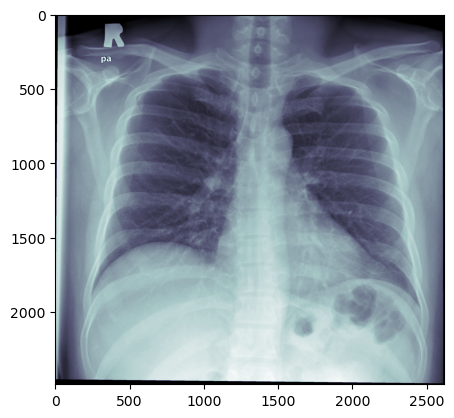

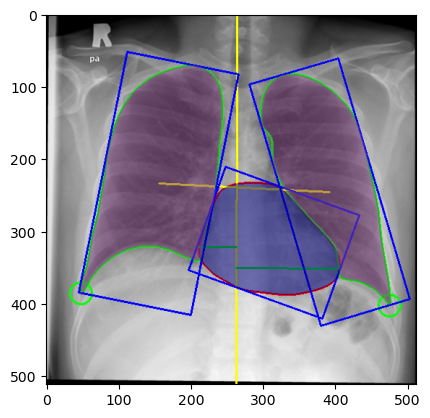

In [105]:
PATH = '../../../../Documents/cardio/cxr_test_samples/'
path = Path(PATH)

result_map = dict()

for idx, zip_path in enumerate(path.glob('*.zip')):
    if zip_path.name != '023.zip':
        continue

    print(zip_path.name)
    with ZipFile(str(zip_path.absolute())) as zip_file:
        cxr_file_info = zip_file.filelist[3]
        cxr_file = zip_file.open(cxr_file_info)

        try:
            ds = read_file(cxr_file, force=True)
            print(f"ID: {ds[0x10, 0x20].value}")
            rescale_pixel = (ds.pixel_array - 0) / pow(2, ds[0x0028, 0x0101].value)
            plt.imshow(rescale_pixel, cmap=plt.cm.bone)
            image = (
                torch.tensor(rescale_pixel, device=device, dtype=torch.float32)
                .repeat(3, 1, 1)
                .unsqueeze(0)
            )

            model.eval()
            with torch.no_grad():
                original_image = resize(image, [512, 512], interpolation=InterpolationMode.BILINEAR)
                image = preprocessor(original_image)
                output_tensor = model(image)

                visualization_tensor, ctr_value = generate_visualization_with_bbox(
                    original_image,
                    output_tensor,
                    output_tensor,
                )
        except Exception:
            traceback.print_exc()
            print('Failed')
            print()
            result_map[zip_path.name] = -1
            continue

        result_map[zip_path.name] = ctr_value
        print(ctr_value)
        print()

        plt.figure()
        plt.imshow(visualization_tensor.permute([1, 2, 0]), cmap=plt.cm.bone)

In [23]:
for key in sorted(result_map.keys()):
    print(round(result_map[key], 2))

0.42
0.55
0.53
0.48
0.47
0.54
0.59
0.51
0.54
0.54
0.54
0.43
0.57
0.41
0.54
0.57
0.5
0.54
0.47
0.51
0.4
-1
0.46
-1
0.52
0.52
0.47
0.49
0.46
0.49
0.48
0.44
0.6
0.48
0.46
0.47
0.57
0.54
0.51
0.53
0.44
0.54
0.48
0.52
0.6
0.46
0.71
0.42
0.51
0.51
0.44
0.47
0.49
0.5
0.41
0.54
0.54
0.48
0.41
0.45
0.57
0.48
0.49
0.47
0.55
0.52
0.5
0.65
0.43
0.52
0.54
0.47
0.43
0.51
0.48
0.49
0.56
0.46
0.54
0.52
0.44
0.39
0.52
0.57
0.48
0.48
-1
0.51
0.53
0.39
0.53
0.52
0.38
0.46
0.56
0.47
0.47
0.48
0.53
0.62
0.48
0.61
0.48
0.46
0.42
0.48
0.54
0.6
0.4
0.43
0.54
0.41
0.44
0.46
0.44
0.48
0.55
0.53
0.56
0.44
0.46
0.57
0.52
0.48
0.47
0.5
0.59
0.46
0.43
0.63
0.63
0.49
0.45
0.5
0.45
0.51
0.48
0.45
0.52
0.48
0.44
0.52
0.51
0.51
0.55
0.45
0.53
0.53
0.54
0.43
0.49
0.5
0.48
0.45
0.5
0.51
0.51
0.55
0.53
0.53
0.54
0.43
-1
0.55
0.51
0.45
0.53
0.54
0.43
-1
0.48
0.39
0.57
0.41
0.49
0.49
0.45
0.45
0.53
0.55
0.49
0.54
0.43
0.43
0.51
0.4
0.52
0.54
0.54
0.53
0.5
0.46
0.58
0.5
0.54
0.53
0.49
0.45
0.51
0.48
0.63
0.55
0.5
0.52
0.46
0